In [1]:
from tqdm import tqdm
from torch import optim
import torch
import matplotlib.pyplot as plt


from vae import VAE

import numpy as np

from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
composed_transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(torch.flatten)])

train = MNIST('./', download=True,  train=True, transform=composed_transform)
test = MNIST('./', download=True,  train=False, transform=composed_transform)
len(train), len(test)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4170036.20it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 309869.40it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1937252.70it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 66982.16it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



(60000, 10000)

In [3]:
N_EPOCHS = 15

input_dims = train[0][0].shape[-1]
output_dims = train[0][0].shape[-1]

batch_size = 128
hid_dims = 300
n_hid_layers = 2
latent_dims = 20
# device = 'cuda'
device = 'cpu'


train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [4]:
# BCE reconstuction loss
vae = VAE(input_dim=input_dims,
          hidden_dim=hid_dims,
          output_dim=output_dims,
          latent_dim=latent_dims,
          n_hid_layers=n_hid_layers).to(device)
opt = optim.Adam(vae.parameters(), lr=0.0005)
rec_loss_hist, kl_loss_hist = [], []

print(sum([p.numel() for p in vae.parameters() if p.requires_grad]))

851024


2990.206787109375, rec_loss=2213.310791015625, kl_loss=776.89599609375: 100%|██████████| 15/15 [02:01<00:00,  8.12s/it]


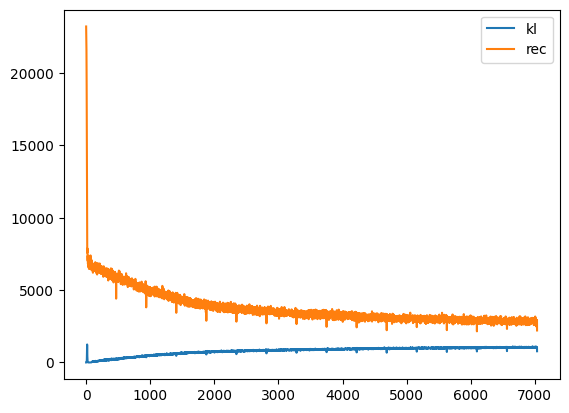

In [ ]:



for _ in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (X_batch, _) in enumerate(train_loader):
        opt.zero_grad()
        X_batch = X_batch.to(device)
        data_hat, mu, logvar = vae(X_batch)
        loss, rec_loss, kl_loss = vae.loss_mse(X_batch, data_hat, mu, logvar, 1)
        rec_loss = rec_loss.detach().cpu().item()
        kl_loss = kl_loss.detach().cpu().item()
        loss.backward()
        opt.step()
        rec_loss_hist.append(rec_loss)
        kl_loss_hist.append(kl_loss)
    pbar.set_description(f'{loss.detach().cpu().item():=}, {rec_loss=}, {kl_loss=}')

plt.plot(kl_loss_hist, label='kl')
plt.plot(rec_loss_hist, label='rec')
plt.legend();

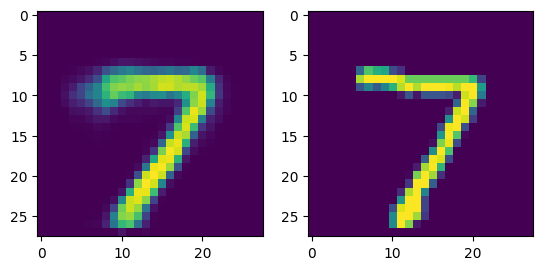

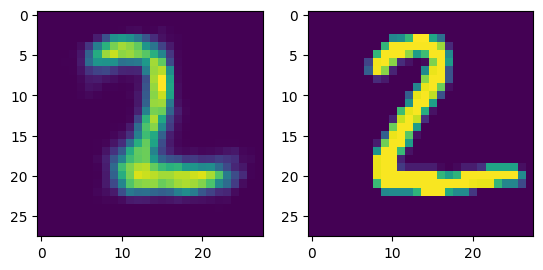

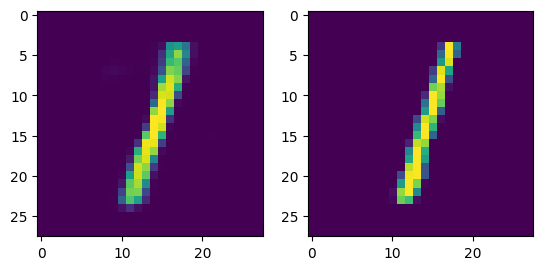

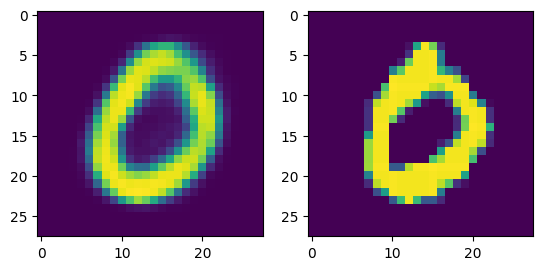

In [11]:
# Let's check reconstructio loss here

n_samples = 4
test_samples, _ = next(iter(test_loader))
test_samples = test_samples.to(device)

with torch.no_grad():
    recon, _, _ = vae(test_samples)


for i in range(n_samples):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(recon[i].cpu().numpy().reshape(28, 28))
    axs[1].imshow(test_samples[i].cpu().numpy().reshape(28, 28))
    fig.show()

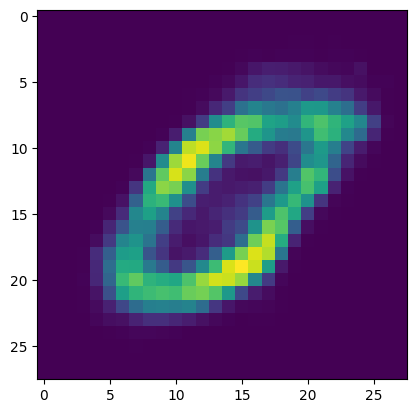

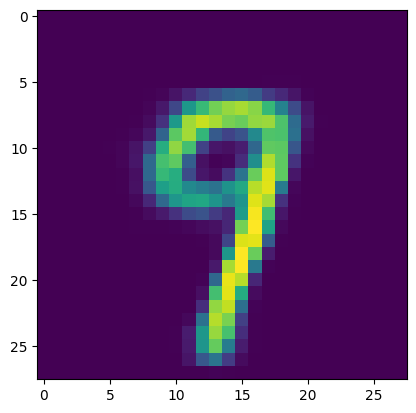

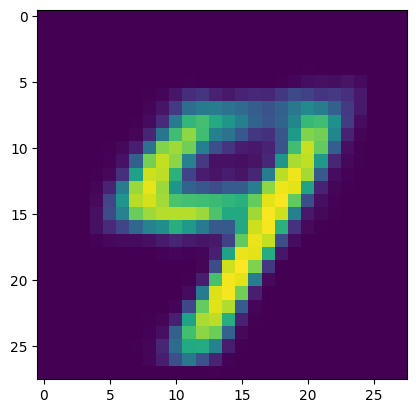

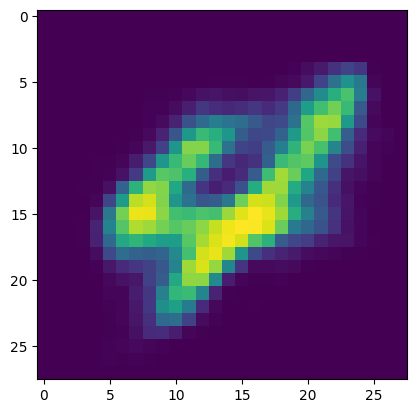

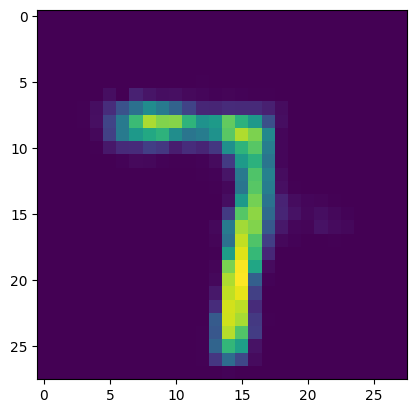

In [13]:
# Let's sample some numbpers
n_samples = 5

with torch.no_grad():
    samples = vae.decode(torch.randn(n_samples, latent_dims, device=device))
for i in range(n_samples):
    plt.imshow(samples[i].cpu().numpy().reshape(28, 28))
    plt.show()